In [1]:
import pandas 
import time
from tqdm import tqdm
import seaborn as sns
import numpy
from textblob import TextBlob
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

C:\Users\lavanya\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = SentenceTransformer('msmarco-distilbert-base-v2')

In [3]:
import pandas as pd
data = pd.read_csv('wiki_movie.csv', memory_map = True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      499 non-null    int64 
 1   Title             499 non-null    object
 2   Origin/Ethnicity  499 non-null    object
 3   Director          499 non-null    object
 4   Wiki Page         499 non-null    object
 5   Plot              499 non-null    object
dtypes: int64(1), object(5)
memory usage: 23.5+ KB


In [5]:
import gc

In [6]:
df = data[['Title','Plot']]

In [7]:
del data

In [8]:
gc.collect()

53

In [9]:
df.dropna(inplace = True)
df.drop_duplicates(subset = ['Plot'], inplace = True)

In [10]:
df['doc_len'] = df['Plot'].apply(lambda words:len(words.split()))

C:\Users\lavanya\AppData\Local\Temp\ipykernel_20932\3328213806.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['doc_len'], hist = True, kde = True, color = 'b', label = 'doc_len')


<Axes: xlabel='doc_len', ylabel='Density'>

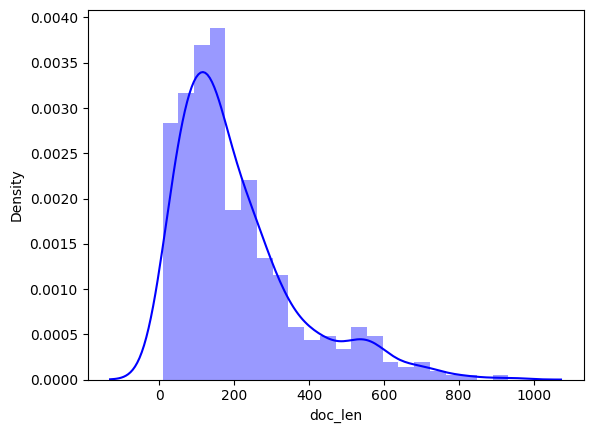

In [11]:
import numpy as np
max_seq_len = np.round(df['doc_len'].mean() + df['doc_len'].std()).astype(int)
sns.distplot(df['doc_len'], hist = True, kde = True, color = 'b', label = 'doc_len')

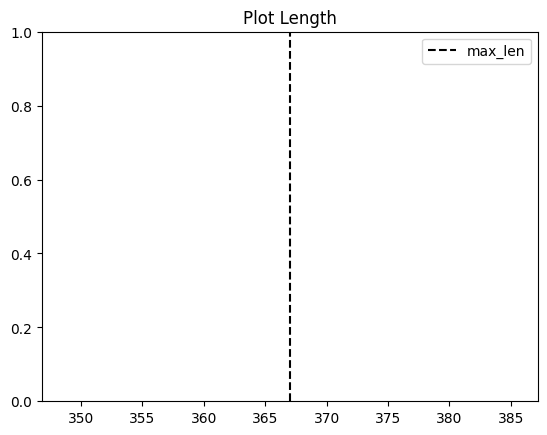

In [12]:
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max_len')
plt.title('Plot Length')
plt.legend()
plt.show()


In [13]:
import faiss

In [14]:
encoded_data = model.encode(df['Plot'].tolist()) 
encoded_data = np.asarray(encoded_data).astype('float32')

In [15]:
index = faiss.IndexIDMap(faiss.IndexFlat(768))
index.add_with_ids(encoded_data, np.array(range(0, len(df))))
faiss.write_index(index, 'movie_plot.index')

In [16]:
def fetch_movie_info(dataframe_idx):
    info = df.iloc[dataframe_idx]
    meta_dict = {}
    meta_dict['Title'] = info['Title']
    meta_dict['Plot'] = info['Plot'][:500]
    return meta_dict

In [17]:
def search(query, top_k, index, model):
    t = time.time()
    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)
    print('>>>> Results in Total Time : {}'.format(time.time()-t))
    
    top_k_ids = top_k[1].tolist()[0]
    top_k_ids = list(np.unique(top_k_ids))
    results = [fetch_movie_info(idx) for idx in top_k_ids]
    return results

In [18]:
from pprint import pprint

In [19]:
query = "roses and flowers"
results = search(query, top_k = 3, index = index, model = model)

>>>> Results in Total Time : 0.03256678581237793


In [20]:
print("\n")

In [21]:
for result in results:
    print('\t', pprint(result))

{'Plot': 'Sad, lonely and unhappy, an old man sits in a city park, thinking '
         'about the past. A little girl comes up to him and takes his hand, '
         'asking him what is making him so sad. The child reminds him of his '
         'own lost little girl and the times of the past begin to flow through '
         'his memory. He had a happy life with a loving wife and baby '
         'daughter. But he wanted to give them more, so he headed West to the '
         'gold fields. The work was long and hard; he was able to keep going '
         'with the thought of what he could do ',
 'Title': 'Sweet and Low'}
	 None
{'Plot': 'When young Chinese woman Lotus Flower sees an unconscious man '
         'floating in the water at the seashore, she quickly gets help for '
         'him. The man is Allen Carver, an American. Soon the two have fallen '
         'in love, and they get married "Chinese fashion". Carver promises to '
         "take her with him when he returns home. Lotus Fl

In [22]:
paragraphs = df['Plot'].tolist()

In [23]:
from transformers import T5Tokenizer
from transformers import T5ForConditionalGeneration
import torch

In [24]:
model_name = "t5-small"
model = T5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(model_name)
model.eval()


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=True`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [25]:
#pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/cpu/torch_stable.html

In [26]:
conda install pytorch torchvision torchaudio cudatoolkit=11.1 -c pytorch

Solving environment: ...working... unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
Solving environment: ...working... unsuccessful initial attempt using frozen solve. Retrying with flexible solve.

Note: you may need to restart the kernel to use updated packages.


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/msys2/win-64/current_repodata.json HTTP/1.1" 304 0
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/r/win-64/current_repodata.json HTTP/1.1" 304 0
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/main/noarch/current_repodata.json HTTP/1.1" 304 0
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/msys2/noarch/current_repodata.json HTTP/1.1" 304 0
DEBUG

In [28]:
import torch
print(torch.cuda.is_available())

False


In [29]:
devices = 'cpu'
model.to(devices)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [31]:
batch_size = 8
num_queries = 5
max_length_paragraph = 512
max_length_query = 64

In [32]:
def _removeNonAscii(s): return " ".join(i for i in s if ord (i) < 128)

In [37]:
with open('generated_queries_all.tsv','w') as fOut:
    for start_idx in tqdm(range(0, len(paragraphs), batch_size)):
        sub_paragraphs = paragraphs[start_idx : start_idx + batch_size]
        
        inputs = tokenizer.prepare_seq2seq_batch(sub_paragraphs, 
                                                 max_length = max_length_paragraph, 
                                                 truncation = True, 
                                                 return_tensors = 'pt')
        
        outputs = model.generate(**inputs,
                                max_length = max_length_query,
                                do_sample = True,
                                top_p = 0.95,
                                num_return_sequences = num_queries)
        
        for idx, out in enumerate(outputs):
            query = tokenizer.decode(out, skip_special_tokens = True)
            query = _removeNonAscii(query)
            para = sub_paragraphs[int(idx/num_queries)]
            para = _removeNonAscii(para)
            fOut.write("{}\t{}\n".format(query.replace("\t", " ").strip(), para.replace("\t", " ").strip()))

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [28:08<00:00, 27.23s/it]


In [38]:
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets
from torch import nn
import os

In [39]:
train_examples = []
with open('generated_queries_all.tsv') as fIn:
    for line in fIn:
        try:
            query, paragraph = linestrip().split('\t', maxsplit=1)
            train_examples.append(InputExample(texts = [query, paragraph]))
        except:
            pass

In [41]:
import random
random.shuffle(train_examples)

In [46]:
pip install sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [48]:
# train_dataloader = datasets.NoDuplicatesDataLoader(train_examples, batch_size = 8)
# word_emb = models.Transformer('sentence-transformers/msmarco-distilbert-base-dot-prod-v3')
# pooling = models.Pooling(word_emb.get_word_embedding_dimension())
# model = SentenceTransformer(modules = [word_emb, pooling])
# train_loss = losses.MultipleNegativeRankingLoss(model)


from torch.utils.data import DataLoader
word_emb = models.Transformer('sentence-transformers/msmarco-distilbert-base-dot-prod-v3')
pooling = models.Pooling(word_emb.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_emb, pooling])
train_loss = losses.CosineSimilarityLoss(model)


In [49]:
num_epochs = 3
warmup_steps = int(len(train_dataloader)*num_epochs*0.1)
model.fit(train_objectives = [(train_dataloader, train_loss)],
         epochs = num_epochs,
          warmup_steps = warmup_steps,
         show_progress_bar = True)

Epoch:   0%|                                                                                     | 0/3 [00:00<?, ?it/s]
Iteration: 0it [00:00, ?it/s]

Iteration: 0it [00:00, ?it/s]

Iteration: 0it [00:00, ?it/s]
Epoch: 100%|████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.35it/s]


In [50]:
os.makedirs('search',exist_ok = True)
model.save('search/search_model')

In [52]:
from sentence_transformers import SentenceTransformer, SentencesDataset, losses, models

import gzip
import json
import os

In [53]:
model = SentenceTransformer('./search/search_model')

In [55]:
!zip -r search_model.zip('./search_model')

'zip' is not recognized as an internal or external command,
operable program or batch file.


In [57]:
encoded_data = model.encode(df.Plot.tolist())
encoded_data = np.array(encoded_data.astype('float32'))

In [58]:
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(df))))
faiss.write_index(index, 'movie_plot.index')

In [59]:
from pprint import pprint

In [60]:
query = "Terrors attack and people running around for help"
results = search(query, top_k = 3, index = index, model = model)

>>>> Results in Total Time : 0.22563409805297852


In [61]:
print('\n')

In [62]:
for result in results:
    print('\t', pprint(result))

{'Plot': 'The film is about a family who move to the suburbs, hoping for a '
         'quiet life. Things start to go wrong, and the wife gets violent and '
         'starts throwing crockery, leading to her arrest.',
 'Title': 'The Suburbanite'}
	 None
{'Plot': 'The plot is that of a black woman going to the dentist for a '
         'toothache and being given laughing gas. On her way walking home, and '
         "in other situations, she can't stop laughing, and everyone she meets "
         '"catches" the laughter from her, including a vendor and police '
         'officers.',
 'Title': 'Laughing Gas'}
	 None
{'Plot': 'A thug accosts a girl as she leaves her workplace but a man rescues '
         'her. The thug vows revenge and, with the help of two friends, '
         "attacks the girl and her rescuer again as they're going for a walk. "
         'This time they succeed in kidnapping the rescuer. He is bound and '
         'gagged and taken away in a cart. The girl runs home and get